In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
from tqdm import tqdm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Regresión Logística

Algoritmo de CLASIFICACIÓN, que tradicionalmente es binario

In [2]:
df = pd.read_csv(os.getcwd() + "\\data\\2008_small.csv",nrows=100000)
df = df[["AirTime","Distance","TaxiOut","ArrDelay","DepDelay"]].dropna()

X = df[df.columns[df.columns != "ArrDelay"]]
filtro = df["ArrDelay"] > 10 
df["ArrDelay"][filtro] = "Delayed"
df["ArrDelay"][filtro== False] = "Not Delayed"
Y = df["ArrDelay"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=2)

In [3]:
clf = LogisticRegression(penalty = "none").fit(X_train, y_train)
predicciones = clf.predict(X_test)

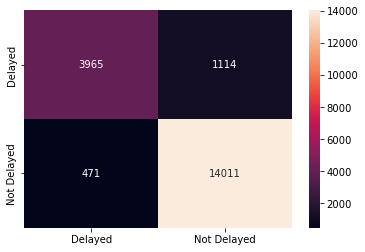

In [37]:
confusion = confusion_matrix(y_test,predicciones)
ax = sns.heatmap( confusion, annot=True,fmt='.6g',
            xticklabels= clf.classes_, 
            yticklabels=clf.classes_)

# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

In [41]:
y_test.value_counts() / len(y_test)

Not Delayed   0.740
Delayed       0.260
Name: ArrDelay, dtype: float64

In [38]:
np.mean(predicciones == y_test)

0.9189714227288993

In [6]:
f1_score(y_test, predicciones, average='macro')

0.8899431386333503

In [7]:
clf.classes_

array(['Delayed', 'Not Delayed'], dtype=object)

In [8]:
predicciones

array(['Not Delayed', 'Delayed', 'Not Delayed', ..., 'Not Delayed',
       'Not Delayed', 'Not Delayed'], dtype=object)

In [ ]:
clf.predict_proba(X_test).round(4)

In [49]:
prob_delayed = clf.predict_proba(X_test)[:,0]

delayedseguras = prob_delayed > 0.6
notdelayedseguras = prob_delayed < 0.4
torevise = (prob_delayed >= 0.4) & (prob_delayed <= 0.6)

In [57]:
X_test[delayedseguras]

,AirTime,Distance,TaxiOut,DepDelay
46242,137.000,1062,14.000,84.000
57991,106.000,694,13.000,46.000
36435,63.000,526,50.000,123.000
26472,33.000,153,22.000,85.000
3411,169.000,802,14.000,-4.000
...,...,...,...,...
62902,93.000,644,9.000,90.000
4797,203.000,1372,22.000,110.000
47573,107.000,802,20.000,34.000
22807,65.000,413,28.000,10.000


# Árbol de Regresión

In [115]:
df = pd.read_csv(os.getcwd() + "\\data\\2008_small.csv",index_col = 0, nrows = 200000)

In [116]:
df = df.dropna(subset = ["ArrDelay"])
df = df[df.AirTime > 0]

X = df[['AirTime','Distance','TaxiIn','TaxiOut', 'DepDelay']]
Y = df[["ArrDelay"]]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=2)

arbol = tree.DecisionTreeRegressor()
arbol = arbol.fit(X_train, y_train)

prediccionesINTERNA = arbol.predict(X_train)
print("R2 INTERNA: ",r2_score(y_train, prediccionesINTERNA))

prediccionesEXTERNA = arbol.predict(X_test)
print("R2 EXTERNA: ",r2_score(y_test, prediccionesEXTERNA))

R2 INTERNA:  0.9999627244847715
R2 EXTERNA:  0.8813908477516473


Ajuste de parámetros (ensayo y error)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=2)

In [86]:
arbol = tree.DecisionTreeRegressor(max_depth=10)
arbol = arbol.fit(X_train, y_train)

prediccionesINTERNA = arbol.predict(X_train)
print("R2 INTERNA: ",r2_score(y_train, prediccionesINTERNA))

prediccionesEXTERNA = arbol.predict(X_test)
print("R2 EXTERNA: ",r2_score(y_test, prediccionesEXTERNA))

R2 INTERNA:  0.9335996549350403
R2 EXTERNA:  0.9199303669004257


### Ensayo de parámetros (más automatizado)

Estructura de guardado de datos (basada en una función de R, llamada expand.grid)

In [107]:
from itertools import product

# Esta función no hace falta entenderla en detalle :)
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

parametros = {'semillas': range(0,15), # Vamos a hacer 10 conjuntos distintos de train/test
              'profundidades': range(3,25,1), #Vamos a probar profundidades 1, 4, 7..
              'splitter': ["best", "random"], #Y vamos a seleccionar la variable de cada partición de manera óptima / aleatoria
              'R2': [np.nan]}

dfparam = expand_grid(parametros) # Crea un dataframe con todas las combinaciones de parámetros
dfparam.head(10)

,semillas,profundidades,splitter,R2
0,0,1,best,NaN
1,0,1,random,NaN
2,0,2,best,NaN
3,0,2,random,NaN
4,0,3,best,NaN
5,0,3,random,NaN
6,0,4,best,NaN
7,0,4,random,NaN
8,0,5,best,NaN
9,0,5,random,NaN


In [98]:
for semilla in tqdm(parametros["semillas"]):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=semilla)
    for prof in parametros["profundidades"]:
        for split in parametros["splitter"]:
  
            arbol = tree.DecisionTreeRegressor(max_depth=prof, splitter=split)
            arbol = arbol.fit(X_train, y_train)

            prediccionesEXTERNA = arbol.predict(X_test)
            dfparam.loc[(dfparam.semillas == semilla) & (dfparam.profundidades == prof) & (dfparam.splitter == split),"R2"] = r2_score(y_test, prediccionesEXTERNA)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


In [108]:
for i in tqdm(range(dfparam.shape[0])):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, 
                                                        random_state=dfparam.loc[i,"semillas"])
    
    arbol = tree.DecisionTreeRegressor(max_depth=dfparam.loc[i,"profundidades"], 
                                       splitter=dfparam.loc[i,"splitter"])
    arbol = arbol.fit(X_train, y_train)

    prediccionesEXTERNA = arbol.predict(X_test)
    dfparam.loc[i,"R2"] = r2_score(y_test, prediccionesEXTERNA)


100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [02:17<00:00,  5.24it/s]


In [109]:
dfparam.sort_values("R2",ascending=False)

,semillas,profundidades,splitter,R2
402,8,10,best,0.929
404,8,11,best,0.929
20,0,11,best,0.928
18,0,10,best,0.928
354,7,10,best,0.928
...,...,...,...,...
193,4,1,random,0.024
145,3,1,random,0.022
433,9,1,random,-0.000
97,2,1,random,-0.000


In [110]:
dfparam.groupby("profundidades").mean()["R2"]

profundidades
1    0.322
2    0.491
3    0.662
4    0.684
5    0.789
6    0.827
7    0.877
8    0.882
9    0.902
10   0.909
11   0.913
12   0.915
13   0.916
14   0.917
15   0.919
16   0.918
17   0.917
18   0.916
19   0.914
20   0.912
21   0.910
22   0.907
23   0.903
24   0.900
Name: R2, dtype: float64

In [111]:
dfparam.groupby("splitter").mean()["R2"].sort_values(ascending=False)

splitter
best     0.885
random   0.792
Name: R2, dtype: float64

In [112]:
dfparam.groupby("semillas").mean()["R2"].sort_values(ascending=False)

semillas
8    0.852
10   0.849
3    0.848
13   0.847
2    0.842
5    0.842
0    0.841
7    0.839
6    0.839
11   0.838
9    0.836
4    0.832
14   0.828
1    0.826
12   0.819
Name: R2, dtype: float64

In [20]:
dfparam.groupby(["profundidades","splitter"]).mean()["R2"]

profundidades  splitter
1              best       0.531
               random     0.175
4              best       0.875
               random     0.614
7              best       0.917
               random     0.793
10             best       0.924
               random     0.875
13             best       0.922
               random     0.909
16             best       0.918
               random     0.920
19             best       0.912
               random     0.917
Name: R2, dtype: float64

In [21]:
dfparam.sort_values("R2",ascending=False).head(20)

,semillas,profundidades,splitter,R2
118,8,10,best,0.928
6,0,10,best,0.928
104,7,10,best,0.928
120,8,13,best,0.927
106,7,13,best,0.927
8,0,13,best,0.926
13,0,19,random,0.926
48,3,10,best,0.925
11,0,16,random,0.925
62,4,10,best,0.924


In [22]:
dfparam.sort_values("R2",ascending=False).tail(20)

,semillas,profundidades,splitter,R2
56,4,1,best,0.538
70,5,1,best,0.537
28,2,1,best,0.536
112,8,1,best,0.522
42,3,1,best,0.520
113,8,1,random,0.517
98,7,1,best,0.517
0,0,1,best,0.515
45,3,4,random,0.512
87,6,4,random,0.509


# Ejercicios

In [114]:
sns.load_dataset("mpg")

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.000,8,307.000,130.000,3504,12.000,70,usa,chevrolet chevelle malibu
1,15.000,8,350.000,165.000,3693,11.500,70,usa,buick skylark 320
2,18.000,8,318.000,150.000,3436,11.000,70,usa,plymouth satellite
3,16.000,8,304.000,150.000,3433,12.000,70,usa,amc rebel sst
4,17.000,8,302.000,140.000,3449,10.500,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.000,4,140.000,86.000,2790,15.600,82,usa,ford mustang gl
394,44.000,4,97.000,52.000,2130,24.600,82,europe,vw pickup
395,32.000,4,135.000,84.000,2295,11.600,82,usa,dodge rampage
396,28.000,4,120.000,79.000,2625,18.600,82,usa,ford ranger


In [364]:
from sklearn.preprocessing import PolynomialFeatures
from itertools import product
df = pd.read_excel("data\cars.xlsx", index_col=0).dropna() #Carga de datos (limpios)
df = df.reset_index() #Evitamos que aparezcan índices sin datos en el dataframe

# Importación de una función personalizada que permite conseguir un dataframe con todas las combinaciones de parámetros (requiere un diccionario)
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

#Dummies
df["cylinders_cat"] = df["cylinders"].astype("str") # Conversión a string de las variables numéricas que queremos convertir a dummies
df["model_year_cat"] = df["model_year"].astype("str")
df["interaccion"] =  df["model_year_cat"] + " " + df["cylinders_cat"] # Interacción entre variables categóricas
dummies = pd.get_dummies(df[["origin","interaccion"]]) # Conversión a dummies de las variables categóricas

Y = df[["mpg"]] # Selección de la variable respuesta
X = df[["displacement","horsepower","weight","acceleration","model_year","cylinders"]] #Selección de las variables numéricas explicativas

# Escalado
transformados = preprocessing.scale(X) # Escalado de datos (no se guardan)
#X = pd.DataFrame(transformados, columns = X.columns) # Descomentar si queremos escalar datos numéricos

# Polinomios
poly = PolynomialFeatures(interaction_only=True) # Creo las interacciones entre variables numéricas
X_poly = poly.fit_transform(X) # Creo la variable con las interacciones
X = pd.DataFrame(X_poly, columns = poly.get_feature_names(X.columns)) #Sobreescribo X
X = pd.concat([X,dummies],axis = 1) # Descomentar si queremos añadir dummies

#Creamos el dataframe con las combinaciones de parámetros y semillas que queremos probar
parametros = {'semillas': range(0,20),'profundidades': range(2,30,1),'splitter': ["best", "random"],'R2': [np.nan]}
dfparam = expand_grid(parametros) 

# Entrenamos y evaluamos todas las combinaciones! (bucle por filas del dataframe de parámetros)
for i in tqdm(range(dfparam.shape[0])):
    #Creamos el conjunto train test con la semilla correspondiente
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, 
                                                        random_state=dfparam.loc[i,"semillas"])
    
    # Creamos el árbol con los parámetros que le corresponden
    arbol = tree.DecisionTreeRegressor(max_depth=dfparam.loc[i,"profundidades"], 
                                       splitter=dfparam.loc[i,"splitter"],random_state=1)
    arbol = arbol.fit(X_train, y_train) # Ajustamos el árbol con los datos

    prediccionesEXTERNA = arbol.predict(X_test) # Hacemos las predicciones con los datos que el modelo aún no ha visto
    dfparam.loc[i,"R2"] = r2_score(y_test, prediccionesEXTERNA) # Añadimos al dataframe los resultados del R2 externo

# Mostramos las mejores combinaciones de parámetros y semilla
resultados = dfparam.groupby(["profundidades","splitter"]).mean().sort_values("R2",ascending = False)["R2"]
resultados

100%|█████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:05<00:00, 194.78it/s]


profundidades  splitter
6              best       0.826
5              best       0.819
4              best       0.812
7              best       0.809
8              best       0.806
9              best       0.804
3              best       0.804
7              random     0.802
8              random     0.800
14             best       0.800
15             best       0.796
14             random     0.796
10             best       0.795
11             best       0.794
16             best       0.794
12             best       0.793
17             best       0.793
16             random     0.792
6              random     0.792
25             best       0.791
23             best       0.791
26             best       0.791
21             best       0.791
29             best       0.791
20             best       0.791
28             best       0.791
18             best       0.791
24             best       0.791
22             best       0.791
27             best       0.791
19             b

In [362]:
resultados.index[0]

(6, 'best')

In [351]:
resultados.index[0]

arbol = tree.DecisionTreeRegressor(max_depth=resultados.index[0][0], 
                                   splitter=resultados.index[0][1],
                                   random_state=1)
arbol = arbol.fit(X, Y)

1. Estudia el dataframe, se llama mpg, puedes buscar qué significan exactamente las variables, y hacer una descripción (numérica y gráfica) de las que te parezcan más relevantes

2. Ajusta un modelo predictivo sencillo para el el consumo del coche (mpg). Evalúa su potencial predictivo tanto interna como externamente

3. Ajusta algunos de los parámetros que conocemos (o alguno nuevo) para intentar mejorar las predicciones

4. Ajusta los parámetros que creas convenientes (o explora algunos nuevos), intenta replicar una estructura de tipo bucle para hacerlo, mostrando los mejores resultados que hayas encontrado

### Clasificación 

1. Ajusta un modelo predictivo para el origen de los coches, o categoriza una variable como el consumo o el peso de los coches

2. Evalúa el modelo predictivo de varias formas

3. Ajusta los parámetros que creas convenientes, intenta replicar una estructura de tipo bucle para hacerlo, mostrando los mejores resultados que hayas encontrado

4. Compara distintos modelos de clasificación, cuál funciona mejor?

### Clustering

1. Intenta agrupar los coches usando el algoritmo DBSCAN

 1    186
 0     80
 2     67
-1     59
dtype: int64


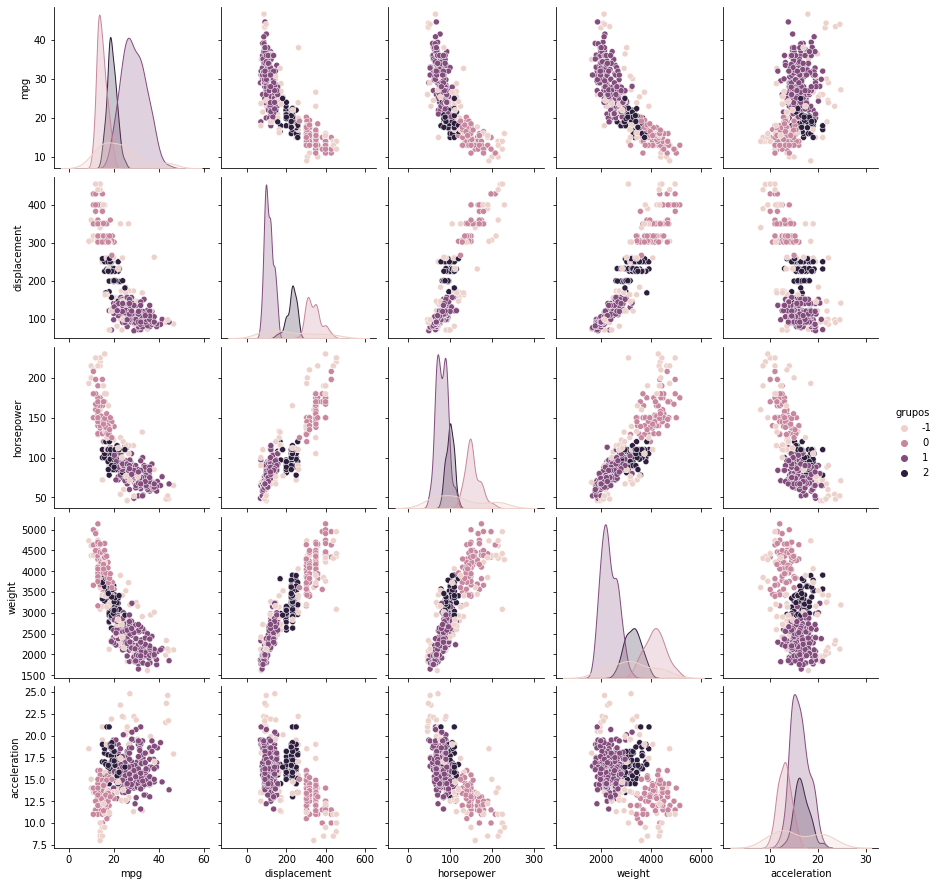

In [15]:
from sklearn.cluster import DBSCAN

df = pd.read_excel("data\cars.xlsx", index_col=0).dropna() 
df = df.reset_index(drop = True) 

X = df[["mpg","displacement","horsepower","weight","acceleration","model_year","cylinders"]] 

transformados = preprocessing.scale(X)
X = pd.DataFrame(transformados, columns = X.columns) 

clustering = DBSCAN(eps=0.95, min_samples=10).fit(X)

df["grupos"] = clustering.labels_
print( pd.DataFrame(clustering.labels_).value_counts() )

sns.pairplot(df[["mpg","displacement","horsepower","weight","acceleration","grupos"]] , hue = "grupos");

In [18]:
pd.crosstab(df["origin"],df["grupos"],margins = True)

grupos,-1,0,1,2,All
origin,,,,,
europe,15,0,52,1,68
japan,9,0,68,2,79
usa,35,80,66,64,245
All,59,80,186,67,392


2. Representa gráficamente los resultados, qué cantidad de grupos te parecen razonables?

3. Juega con el parámetro eps a ver qué diferencias se observan

4. Compara con los demás algoritmos de clústering que hemos visto!

5. Hay alguna correspondencia entre los grupos generados y la variable "origin"?